# <center>Ch4 强化学习PPO详解 </center>

# 为什么要学习强化学习

1. ChatGPT的成功
   - 使用RLHF(基于人类反馈的强化学习)进行微调
   - 显著提升了模型的实用性和安全性

2. RLHF的核心算法就是PPO
   - PPO用于从人类反馈中学习
   - 帮助模型更好地对齐人类偏好

3. 带动PPO算法的关注
   - 研究者开始深入研究PPO原理
   - 工程师学习PPO以便应用到自己的项目

**RLHF为什么选择PPO？**
1. PPO特性非常适合RLHF场景：
   - 策略裁剪防止过度更新
   - 训练稳定性好
   - 实现相对简单

2. 实践证明效果好：
   - ChatGPT成功验证了PPO在RLHF中的效果
   - 其他公司也纷纷采用类似方案

**学习PPO的现实意义**
1. 理解RLHF的技术原理
   - 了解大模型是如何从人类反馈中学习的
   - 掌握对齐人类偏好的关键技术

2. 实际应用需求
   - 很多公司在尝试复现RLHF
   - PPO成为大模型微调的必备知识


PPO 核心函数 
$$
L^{CLIP}(\theta) = \mathbb{E}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t \right) \right]
$$


# 1.强化学习基本概念讲解 

智能体(Agent)与环境(Environment)的交互   
状态(State)：环境在某时刻的描述   
动作(Action)：智能体可以执行的行为    
奖励(Reward)：环境对动作的反馈      
策略(Policy)：决定在某状态下采取什么动作   

滑雪游戏来详细解释这些概念：

1. 智能体(Agent)与环境(Environment)的交互：
- 智能体：滑雪者(AI控制的角色)
- 环境：整个滑雪场景，包括雪道、障碍物、旗门等
- 交互过程：
  * 滑雪者观察前方路况
  * 决定如何移动
  * 环境返回新的画面和得分


2. 状态(State)：
- 表示当前游戏画面的关键信息：
  * 滑雪者的位置
  * 滑雪者的速度
  * 前方障碍物的位置（树木、石头）
  * 旗门的位置
  * 地形的坡度
  * 与最近障碍物的距离

3. 动作(Action)：
- 滑雪者可以执行的操作：
  * 向左转
  * 向右转
  * 直行
  * 减速
  * 加速

4. 奖励(Reward)：
- 游戏给出的即时反馈：
  * 成功通过旗门：+10分
  * 收集金币：+1分
  * 撞到障碍物：-50分
  * 安全滑行：+0.1分/步
  * 到达终点：+100分
  * 摔倒或撞树：游戏结束，-100分

5. 策略(Policy)：
- AI学到的"经验法则"，例如：
  * 看到前方有树→向旁边转向避开
  * 看到旗门→调整方向以通过旗门
  * 看到开阔地形→可以加速
  * 看到危险地形→提前减速

整个学习过程是这样的：
1. AI观察当前画面(状态)
2. 根据学到的策略选择动作(转向/加速等)
3. 执行动作，游戏状态发生变化
4. 获得相应的奖励(分数)
5. 根据这次经验调整策略
6. 不断重复这个过程

PPO算法的特点：
- 像一个谨慎的教练，每次只对策略做小幅调整
- 比如：
  * 如果发现某个动作效果好(成功避开障碍)
  * 会稍微增加在类似情况下选择该动作的概率
  * 但不会一下子改变太多，避免过度调整

通过这样的学习：
- AI逐渐掌握如何安全且高效地滑雪
- 学会在不同情况下做出合适的反应
- 最终目标是获得最高的累积分数

目标：
- 通过不断尝试和学习
- 找到一个最优策略
- 使得长期累积奖励最大化

这就是强化学习最基础的框架，PPO算法就是在这个框架下，提出了一种更有效的策略学习方法。


# 2.PPO前置概念学习

## 2.1 马尔可夫决策过程(MDP)

马尔可夫决策过程是一个数学框架，用于描述智能体与环境交互的过程。它包含5个基本要素(S, A, P, R, γ):

1. 状态空间(State Space) S:
- 描述环境在某一时刻的所有可能状态
- 在滑雪游戏中包括:
  * 滑雪者的位置坐标(x,y)
  * 滑雪者的速度
  * 前方障碍物的位置
  * 当前得分等

2. 动作空间(Action Space) A:
- 智能体在每个状态下可以采取的所有可能动作
- 在滑雪游戏中包括:
  * 向左转
  * 向右转
  * 加速
  * 减速等

3. 状态转移概率(State Transition Probability) P(s'|s,a):
- 理论定义：在状态s下执行动作a后，转移到状态s'的概率
- 在滑雪游戏中：
  * s：当前状态(位置、速度、前方障碍物等)
  * a：执行的动作(如向左转)
  * s'：可能的下一个状态
- 具体例子：   

  当前状态s：
  - 位置：(x=100, y=200)
  - 速度：10m/s
  - 前方5米处有树
  
  动作a：向左转30度
  
  可能的下一状态s'及其概率：
  1. 80%概率：
     - 新位置：(x=97, y=204)
     - 速度：9m/s
     - 成功避开树
  2. 15%概率：
     - 新位置：(x=99, y=204)
     - 速度：9m/s
     - 仍在撞树路径上
  3. 5%概率：
     - 新位置：(x=95, y=203)
     - 速度：7m/s
     - 失去平衡

4. 奖励函数(Reward Function) R(s,a,s'):
- 执行动作a从状态s转移到s'时获得的即时奖励
- 例如:
  * 安全滑行: +1分
  * 撞树: -50分
  * 通过旗门: +10分
  * 到达终点: +100分

5. 折扣因子(Discount Factor) γ:
- 用于权衡即时奖励和未来奖励的重要性
- 取值范围[0,1]
- 例如γ=0.9时:
  * 当前获得的10分 = 10分
  * 1步后获得的10分 = 10 × 0.9 = 9分
  * 2步后获得的10分 = 10 × 0.9² = 8.1分

这5个要素共同定义了一个完整的决策问题:
1. 智能体观察当前状态
2. 根据策略选择动作
3. 环境根据转移概率产生新状态
4. 智能体获得相应奖励
5. 不断重复这个过程

目标是找到一个最优策略,使得期望的累积折扣奖励最大化。

## 2.2 折扣因子

数学表达：当前时刻t的奖励 $r_t$ 的未来价值 = $r_t$  ×  $γ^t$ 
- 在滑雪游戏中：
```json
  假设 γ = 0.9，一段滑雪过程的奖励序列：
  t=0: 安全滑行 +1分
  t=1: 通过旗门 +10分
  t=2: 收集金币 +2分
  t=3: 安全滑行 +1分
  
  折扣后的价值：
  1 × (0.9)⁰ = 1         # t=0时刻的奖励,不折扣
  10 × (0.9)¹ = 9        # t=1时刻的奖励,折扣1次 
  2 × (0.9)² = 1.62      # t=2时刻的奖励,折扣2次
  1 × (0.9)³ = 0.729     # t=3时刻的奖励,折扣3次
```

回报(return)：
- 理论定义：从当前时刻开始所有未来奖励的折扣和
- 在滑雪游戏中：
  ```json
  把所有折扣后的价值加起来
   1 (t=0时刻的折扣价值)
   9 (t=1时刻的折扣价值)
   1.62 (t=2时刻的折扣价值)
   0.729 (t=3时刻的折扣价值)

  R0 = 1 + (0.9×10) + (0.9²×2) + (0.9³×1)
     = 1 + 9 + 1.62 + 0.729
     = 12.349
  ```

轨迹
- 理论定义：一个完整的状态-动作-奖励序列
- 在滑雪游戏中：
  ```json
  一次完整滑雪过程的轨迹：
  t=0:
    状态s0: 起点位置(x=0,y=0), 速度=0
    动作a0: 直行
    奖励r0: +1(安全滑行)
  
  t=1:
    状态s1: 位置(x=0,y=10), 速度=5, 前方有旗门
    动作a1: 右转15度
    奖励r1: +10(通过旗门)
  
  t=2:
    状态s2: 位置(x=2,y=20), 速度=7, 前方有树
    动作a2: 左转45度
    奖励r2: +2(收集金币)
  ...直到结束
  ```

这些概念的重要性：
1. 状态转移概率：描述环境的不确定性，帮助AI预测动作后果
2. 折扣因子：平衡短期和长期收益，防止无限累积
3. 回报：提供优化目标，AI的目标是最大化期望回报
4. 轨迹：记录完整经验，用于策略学习和评估


**1.为什么要有折扣因子？**
- 现实原因：
  * 在真实环境中，越远的未来越不确定
  * 比如滑雪时，我们更关注眼前的障碍物，而不是很远处的情况
  * 近期的决策(如避开眼前的树)比远期的决策更重要

- 技术原因：
  * 如果不打折扣，在无限时间的游戏中，总回报可能变成无穷大
  * 即使是+1分的小奖励，无限累积也会变成无穷大
  * 这样会导致无法比较不同策略的好坏

无法比较策略的优劣：
- 如果允许无限累积，任何能让智能体"活着"的策略最终都会得到无限分
- 比如：
  * 策略A：冒险快速到达终点
  * 策略B：在安全区域来回移动
  假设不用折扣因子：
```json
      简单滑行每步+1分：
      10步：10分
      100步：100分
      1000步：1000分
      ...无限步：无限分
```
  * 如果不打折扣，B策略通过无限累积小奖励也能得到无限高分
  * 这样就无法区分哪个策略更好

2. 数学计算问题：
- 无限累积会导致计算发散
- 使用折扣因子后，即使是无限步骤，总回报也会收敛到一个有限值
```json
    使用折扣因子(γ=0.9)：
    10步：1 + 0.9 + 0.9² + ... + 0.9⁹ ≈ 6.51分
    100步：有限值
    无限步：最终收敛到有限值
```

**2. 为什么时刻越晚，折扣越多？**
```json
例如在滑雪过程中：
t=0: 看到树，立即转向避开 (+5分)
t=1: 通过旗门 (+10分)
t=2: 收集远处的金币 (+1分)

使用折扣因子γ=0.9：
当前的5分 = 5 × 0.9⁰ = 5分
1步后的10分 = 10 × 0.9¹ = 9分
2步后的1分 = 1 × 0.9² = 0.81分
```
- 这反映了一个重要思想：
  * 立即避开危险比获得远处的奖励更重要
  * 近期的正确决策对生存更关键
  * 远期的回报存在更多不确定性


**3.PPO怎么平衡折扣因子γ**

1. 长期收益仍然很重要：
- γ通常设置得很接近1（如0.99）
- 这意味着远期收益仍然有很大权重
- AI会考虑长远的决策影响

2. 折扣因子的真正作用：
- 平衡近期和远期收益
- 提供数学上的收敛保证
- 反映未来的不确定性

3. 以滑雪游戏为例：
```json
    设γ=0.99时：
    t=0: 安全滑行 (+1) × 0.99⁰ = 1
    t=1: 通过旗门 (+10) × 0.99¹ = 9.9
    t=10: 到达终点 (+100) × 0.99¹⁰ = 90.4

    AI会权衡：
    - 是否值得冒险通过难度大的旗门
    - 是否应该选择更安全但更长的路线
    - 如何在速度和安全性之间平衡
```
4. 关键点：
- 折扣因子不是为了忽视远期收益
- 而是为了合理权衡近期和远期收益
- 通常γ设置得很接近1（如0.99），表示远期收益仍然很重要


## 2.3 价值函数

价值函数相关：
- 状态价值函数V(s)
- 动作价值函数Q(s,a)
- 优势函数(Advantage)：A(s,a) = Q(s,a) - V(s)

**1. 状态价值函数 V(s)：**
- 定义：从状态s开始，按照当前策略π行动，能获得的期望累积折扣奖励
- 数学表达：$ V(s) = E[r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \cdots] $
- 在滑雪游戏中：


```json
例如某个状态s：
- 位置：在半山腰
- 前方10米有一排旗门
- 左侧15米有树
- 速度适中

V(s)评估这个状态的"价值"：
- 预计能获得的总分数
- 可能包括：
  * 即将通过旗门得到的10分
  * 之后可能收集到的金币
  * 最终到达终点的奖励
  * 减去可能撞树的风险

映射滑雪游戏中一个序列：

t=0 (当前)：
- 状态s0：在起点
- 动作a0：直行
- 奖励R0：安全滑行 +1分

t=1 (下一步)：
- 状态s1：接近旗门
- 动作a1：右转
- 奖励R1：通过旗门 +10分

t=2 (再下一步)：
- 状态s2：遇到金币
- 动作a2：直行
- 奖励R2：收集金币 +2分

计算状态价值V(s0)：
V(s0) = R0 + γR1 + γ²R2
      = 1 + 0.9×10 + 0.9²×2
      = 1 + 9 + 1.62
      = 11.62分
```

**2. 动作价值函数 Q(s,a)：**
- 定义：在状态s下执行动作a，之后按策略π行动能获得的期望累积折扣奖励
- 数学表达：Q(s,a) = R(s,a) + γE[V(s')]
- 在滑雪游戏中：
```json
同样的状态s，考虑不同动作：

Q(s, 向左转)：
- 立即避开树木(+5分)
- 但可能错过旗门(-10分)
- 后续路径较安全

Q(s, 直行)：
- 能通过旗门(+10分)
- 但有撞树风险(-50分)
- 后续路径不确定

Q(s, 向右转)：
- 错过旗门(-10分)
- 完全避开树木(+5分)
- 后续路径较好
```

```json
在滑雪游戏中：
当前状态s：在半山腰
动作a：向左转

即使我们选择了明确的动作，但结果仍是不确定的：
- 可能成功避开树(80%概率)
- 可能转向不够(15%概率)
- 可能失去平衡(5%概率)

考虑两个动作选择：

    动作A：保守转向
    R(s,a) = 5分
    下一状态可能性：
    - 90%：安全位置 V(s1') = 20分
    - 10%：稍差位置 V(s2') = 15分
    Q(s,a) = 5 + 0.9×(0.9×20 + 0.1×15) = 21.85分

    动作B：激进转向
    R(s,a) = 10分
    下一状态可能性：
    - 60%：最佳位置 V(s1') = 30分
    - 30%：一般位置 V(s2') = 10分
    - 10%：危险位置 V(s3') = -20分
    Q(s,a) = 10 + 0.9×(0.6×30 + 0.3×10 + 0.1×(-20)) = 20.9分
```
- 虽然动作B的最好结果更好(30分)
- 但考虑所有可能性后，动作A的期望值更高
- 这帮助AI做出更稳妥的决策

**3. 优势函数 A(s,a)：**
- 定义：A(s,a) = Q(s,a) - V(s)
- 含义：评估在状态s下，执行动作a比平均表现好多少
- 在滑雪游戏中：
```json
假设在状态s：
V(s) = 15分 (该状态的平均预期收益)

各动作的优势值：
A(s, 向左转) = Q(s,左转) - V(s) = 10 - 15 = -5
- 表示比平均表现差5分

A(s, 直行) = Q(s,直行) - V(s) = 20 - 15 = +5
- 表示比平均表现好5分

A(s, 向右转) = Q(s,右转) - V(s) = 12 - 15 = -3
- 表示比平均表现差3分
```

这三个函数的关系：
1. V(s)评估状态的总体价值
2. Q(s,a)评估状态-动作对的价值
3. A(s,a)评估具体动作相对于平均表现的优劣

在PPO算法中：
- 使用神经网络估计V(s)
- 用优势函数A(s,a)来指导策略更新
- 优势值为正的动作会被强化
- 优势值为负的动作会被弱化

MDP中对应的奖励函数 折扣因子 状态空间以及动作空间的区别是什么
1. MDP的基本要素描述了环境：
- 定义了问题的框架
- 描述了环境的动态特性
- 定义了即时奖励规则

2. 价值函数是基于MDP计算出来的：
- 用于评估长期收益
- 帮助做出决策
- 指导策略的学习

## 2.4 策略梯度方法


- 策略参数化：如何用神经网络表示策略
- 目标函数：最大化期望回报
- 策略梯度定理：如何计算梯度

1. 策略参数化：
- 定义：使用神经网络来表示策略π(a|s;θ)，θ是网络参数
- 含义：在状态s下选择动作a的概率

```json
    例如滑雪游戏中：
    输入状态s：
    - 位置坐标(x,y)
    - 速度v
    - 距离最近障碍物距离d
    - 到旗门距离g

    神经网络输出动作概率：
    π(左转|s;θ) = 0.2
    π(直行|s;θ) = 0.3
    π(右转|s;θ) = 0.5

    这里的θ包含神经网络的所有权重和偏置参数

    输入层(状态s)：
    - 节点1：x坐标
    - 节点2：y坐标
    - 节点3：速度
    - 节点4：到树的距离

    隐藏层：
    - 权重W1：连接输入层到隐藏层的权重矩阵
    - 偏置b1：隐藏层的偏置项

    输出层(动作概率)：
    - 权重W2：连接隐藏层到输出层的权重矩阵
    - 偏置b2：输出层的偏置项

    θ就是所有这些参数的集合：θ = {W1, b1, W2, b2}
```

2. 目标函数：
- 定义：J(θ) = E[R₁ + γR₂ + γ²R₃ + ...]
- 含义：在当前策略参数θ下，期望能获得的长期回报

```json
例如一个回合的轨迹：
t=1: 右转，通过旗门，R₁=10
t=2: 直行，收集金币，R₂=2
t=3: 左转，避开树，R₃=5

假设γ=0.9，则该轨迹的回报：
R = 10 + 0.9×2 + 0.9²×5 = 14.05

目标是最大化多个轨迹的期望回报
```


3. 策略梯度定理：
- 定义：$\nabla_{\theta} J(\theta) = \mathbb{E}\left[ \nabla_{\theta} \log \pi(a|s;\theta) \times Q(s,a) \right]$
- 含义：告诉我们如何调整参数θ来提高策略性能

```json
    计算步骤示例：
    假设在某个状态s下：
    1. 当前策略输出的概率：
    - 左转：0.3
    - 直行：0.5
    - 右转：0.2

    2. 策略梯度告诉我们：
    ∇θ = 对参数θ求导
        log(π(a|s;θ)) = 动作概率的对数
        Q(s,a) = 在状态s下采取动作a的价值
    - 如果Q值为正，应该增加这个动作的概率
    - 如果Q值为负，应该减少这个动作的概率
    假设：  
        如果Q(s,左转)=10 (好的结果)
        则增加π(左转|s;θ)的概率

        如果Q(s,直行)=-5 (坏的结果)
        则减少π(直行|s;θ)的概率

    4. 更新后的概率可能变成：
    - 左转：0.4 (因为效果好，概率增加)
    - 直行：0.4
    - 右转：0.2

```

4. 实际应用过程：
```json
    训练循环：
    1. 使用当前策略π(a|s;θ)进行滑雪
    2. 收集状态-动作-奖励序列
    3. 计算每个状态-动作对的Q值
    4. 使用策略梯度定理计算梯度
    5. 更新策略参数θ
    6. 重复这个过程
```
如果某个动作带来了好的回报：
- 其对应的概率会被增加
- 例如：如果右转后成功通过旗门
- 在类似状态下右转的概率会增加


5. 关键点：
- 策略网络直接输出动作概率
- 通过实际尝试来评估动作的好坏
- 根据回报来调整动作概率
- 逐步改进以获得更好的策略

# 3.PPO核心概念

## 3.1 Actor-Critic基础架构

1. 基本概念：
Actor-Critic = Actor(演员) + Critic(评论家)

就像滑雪训练：
- Actor就是滑雪者，负责执行动作
- Critic就是教练，负责评估表现

2. Actor(策略网络)详解：

输入层：状态信息
- 位置坐标(x,y)
- 当前速度
- 前方障碍物位置
- 到旗门距离

隐藏层：特征提取
- 处理输入信息
- 学习状态特征

输出层：动作概率分布    
π(a|s) 表示在状态s下选择动作a的概率
例如：
- 左转: 0.7
- 直行: 0.2
- 右转: 0.1

Actor的工作：
1. 观察当前状态
2. 输出动作概率
3. 根据概率选择动作


3. Critic(价值网络)详解：
  
输入层：与Actor相同的状态信息
- 位置坐标(x,y)
- 当前速度
- 前方障碍物位置
- 到旗门距离

隐藏层：特征提取 
- 处理输入信息
- 学习状态价值特征

输出层：单个价值估计V(s)
- 预测从当前状态开始能获得的总回报
例如：     
V(s) = 25分，表示预计从当前状态开始能得到25分


4. 两者如何协同工作：

步骤1 - 状态观察：
- Actor和Critic都接收当前状态
- 例如：看到前方有树

步骤2 - 各自工作：   
Actor：
- 输出动作概率[0.7, 0.2, 0.1]
- 选择左转(概率0.7最高)

Critic：
- 评估当前状态价值为25分
- 实际执行后得到30分
- 计算优势：30 - 25 = +5

步骤3 - 学习更新：
Actor根据优势更新：
- 优势为正(+5)
- 增加选择左转的概率
- 因为结果比预期好

Critic更新：
- 调整价值预测
- 使预测更准确


5. 在PPO中的应用：

1. 数据收集：
- Actor与环境交互
- 收集(状态,动作,奖励)

2. 优势计算：
- Critic评估状态价值
- 计算实际回报与预测的差

3. 策略更新：
- 使用PPO的裁剪目标函数
- 同时更新Actor和Critic

## 3.2重要性采样

1. 基本概念：

重要性采样是用A策略收集的数据来评估B策略的方法     
关键公式：重要性权重 = 新策略概率/旧策略概率


首先理解PPO的一个重要特点：
```json
PPO不是这样训练的：
收集数据 → 更新一次 → 收集新数据 → 更新一次 → ...

而是这样的：
收集一批数据 → 用这批数据更新多次 → 再收集新数据 → 再更新多次 → ...

```
假设我们收集了一批数据：
- 用策略A收集的
- 策略A说："看到树时，30%概率左转"
- 实际左转了，得到10分

第一次更新后：
- 策略变成了策略B
- 策略B说："看到树时，40%概率左转"
- 但我们手里的数据还是用30%概率收集的

想象成考试：
- 策略A：选择A答案的概率30%
- 选了A，得了10分

现在我们的策略变了：
- 策略B：选择A答案的概率40%
- 但我们还在用策略A时的那次考试成绩
- 这个10分对策略B来说准确吗？


第一轮收集数据：
状态：看到树
动作：左转(30%概率)
结果：+10分

第一次更新后：
- 策略变成40%概率左转
- 调整分数：10 × (40%/30%) = 13.33分
- 说明这个动作不错，应该增加概率

第二次更新：
- 策略变成45%概率左转
- 调整分数：10 × (45%/30%) = 15分
- 继续增加概率

第三次更新：
- 策略变成48%概率左转
- 调整分数：10 × (48%/30%) = 16分


最终效果：
```json
不是选择某一次更新的结果
而是通过多次更新得到一个更好的策略

例如：
初始策略：30%左转
↓ 第一次更新
40%左转
↓ 第二次更新
45%左转
↓ 第三次更新
48%左转

最终使用最后更新的策略继续收集新数据
```

更新多次的意义：
```json
1. 逐步优化：
   - 不是一次性大幅改变策略
   - 而是小步慢走，逐渐改进
   
2. 数据充分利用：
   - 每次更新都能从数据中学到东西
   - 就像反复研究同一场比赛的录像
   
3. 稳定性：
   - 防止策略突变
   - 保持学习的连续性
```

## 3.3 裁剪功能

为什么需要裁剪：

不裁剪的问题：   
如果新策略概率可以无限制变化：
- 可能从30%直接变到90%
- 或者从30%直接降到5%
- 学习过程不稳定



裁剪机制：

设置裁剪范围：[1-ε, 1+ε]    
通常ε = 0.2，所以范围是[0.8, 1.2]

例如：
旧概率：30%
允许的新概率范围：
- 上限：30% × 1.2 = 36%
- 下限：30% × 0.8 = 24%

如果计算出新概率45%：
- 超过了36%
- 会被裁剪到36%


裁剪的作用：

1. 防止策略突变   
2. 保持学习稳定性   
3. 保留已学到的好的经验    


为什么不一步到位：

假设当前状态：看到树    
旧策略：30%概率左转，得10分    

如果直接更新到最大值(1.2倍)：
- 新概率 = 36%(1.2 × 30%)
- 看起来合理

但实际情况可能是：
- 32%时效果最好，得15分
- 34%时开始下降，得12分
- 36%时可能只有8分

所以需要渐进式尝试：    
第1次：31% → 观察效果   
第2次：32% → 效果更好    
第3次：33% → 效果开始下降    
停在32%，而不是盲目到36%   


为什么概率越高可能效果下降：

在滑雪游戏中：    
状态：看到前方有树，且左侧有旗门    

如果左转概率太低(20%)：
- 经常错过避开树的机会
- 容易撞树

如果左转概率适中(32%)：
- 能较好地避开树
- 还能照顾到旗门的收集
- 平衡了安全和得分

如果左转概率太高(40%)：
- 过于倾向左转
- 可能过早转向错过旗门
- 或者转向过度失去平衡
- 反而表现变差


PPO的核心思想：

1. 保守原则：
   - 宁可小步慢走
   - 不要冒进冒险

2. 探索和利用的平衡：
   - 不断尝试略微不同的策略
   - 但不会偏离太远

3. 安全更新：
   - 有多重保护机制
   - 防止策略突变


## 3.4 KL散度

1. 基本概念：

KL散度用来衡量两个概率分布的差异程度    
在PPO中：
- 比较新策略和旧策略的概率分布
- 确保它们不会差得太远


1. 裁剪和KL散度监控的不同点：

裁剪方法只关注单个动作：
状态：看到树
旧策略：
- 左转 30%
- 直行 50%
- 右转 20%

裁剪限制：
- 左转：只能在24%-36%之间
- 直行：只能在40%-60%之间
- 右转：只能在16%-24%之间

但是！即使每个动作都在限制范围内：
新策略：
- 左转：36%(上限)
- 直行：40%(下限)
- 右转：24%(上限)   
整体策略的变化可能已经很大了

KL散度会计算这两个分布的差异
- 差异小说明策略变化温和
- 差异大说明策略变化剧烈


KL散度作用：

裁剪方法的局限：
- 只能逐个限制动作概率
- 看不到整体策略变化

KL散度的价值：
- 提供整体策略变化的度量
- 防止多个"合法"的小变化
- 累积成不稳定的大变化


# 4.PPO核心公式讲解

#### 1. **策略比率** $ r_t(\theta) $

$$
r_t(\theta) = \frac{\pi_\theta(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)}
$$

- $ r_t(\theta) $ 是 **策略比率**，它表示当前策略 $ \pi_\theta $ 与旧策略 $ \pi_{\theta_{\text{old}}} $ 对于某个动作 $ a_t $ 在状态 $ s_t $ 下的概率比率。
- 也就是说，$ r_t(\theta) $ 衡量了当前策略在给定状态下选择某个动作的概率与旧策略选择该动作的概率之间的比率。
```json
    在滑雪游戏中：
    状态st：看到前方有树
    动作at：选择左转
    πθ_old(at|st)：旧策略选择左转的概率 = 30%
    πθ(at|st)：新策略选择左转的概率 = 45%
```
 $ r_t$ (θ) = 45% / 30% = 1.5 
 
  - 如果 $ r_t(\theta) > 1 $，说明新策略相较于旧策略更加倾向于选择这个动作。
  - 如果 $ r_t(\theta) < 1 $，说明新策略选择这个动作的概率较低。
- **目的**：通过调整 $ r_t(\theta) $ 来最大化优势函数 $ \hat{A}_t $，即选取能够提升长期回报的动作。

#### 2. **优势函数** $ \hat{A}_t $

- $ \hat{A}_t $ 是 **优势函数**，它衡量了在某一状态 $ s_t $ 下，选择动作 $ a_t $ 带来的实际回报与期望回报的差异。通常，优势函数是基于 **TD误差**（Temporal Difference Error）或 **GAE（Generalized Advantage Estimation）** 来估算的。
- 具体来说，优势函数可以定义为：
  $$
  \hat{A}_t = Q(s_t, a_t) - V(s_t)
  $$
  其中，$ Q(s_t, a_t) $ 是 **动作价值函数**，表示在状态 $ s_t $ 下选择动作 $ a_t $ 的期望回报；$ V(s_t) $ 是 **状态价值函数**，表示在状态 $ s_t $ 下的期望回报。

```json
  在滑雪游戏中：
    Q(st,at)：选择左转的预期总回报 = 25分
    V(st)：当前状态的平均预期回报 = 20分

    Ât = 25 - 20 = +5

    含义：
    - 正优势(+5)：说明左转比平均表现好
    - 负优势：说明这个动作比平均表现差
```
- **目的**：优势函数的作用是引导策略更新的方向。正的优势函数值意味着当前的动作比平均策略更好，负的优势函数值则意味着当前的动作不理想。

#### 3. **剪切函数** $ \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) $

$$
\text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)
$$

- 这是 **剪切（clip）函数**，它确保策略比率 $ r_t(\theta) $ 不会发生过大的变化。
- **剪切机制**的核心思想是：如果 $ r_t(\theta) $ 超出了 $ [1-\epsilon, 1+\epsilon] $ 的范围，则将其“剪切”回这个区间。这意味着，PPO控制策略更新的幅度，不允许策略发生剧烈变化。
  - 如果 $ r_t(\theta) $ 落在 $ [1-\epsilon, 1+\epsilon] $ 范围内，则不做任何修改，保持原有的比率。
  - 如果 $ r_t(\theta) $ 超出了这个区间，剪切函数将其限制在最大值 $ 1+\epsilon $ 或最小值 $ 1-\epsilon $ 上。
- **目的**：通过限制 $ r_t(\theta) $ 的变化幅度，PPO确保每次更新不会偏离原始策略太远，从而避免了过大的策略更新导致训练不稳定。

#### 4. **最终的目标函数**

$$
L^{CLIP}(\theta) = \mathbb{E}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t \right) \right]
$$

- 这是PPO的**目标函数**，它由两个部分组成：
  - $ r_t(\theta) \hat{A}_t $ 部分：直接使用当前策略比率和优势函数来优化策略。
  - $ \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t $ 部分：通过剪切机制限制策略比率的变化，从而防止过大的更新。     
  
具体计算：    
$r_t$ (θ) = 1.5    
Ât = 5    
ε = 0.2   

第一部分：$r_t$ (θ)Ât   
= 1.5 × 5 = 7.5   

第二部分：clip($r_t$ (θ), 1-ε, 1+ε)Ât   
= clip(1.5, 0.8, 1.2) × 5   
= 1.2 × 5 = 6   

最终：min(7.5, 6) = 6   
- **优化过程**：PPO的优化目标是最大化这个目标函数，具体地，选择一个使得目标函数值最大的策略参数 $ \theta $，以便模型能在环境中获得最大的长期回报。

# 5.PPO代码实现

pip install gymnasium torch numpy==1.24.3 matplotlib

可能会缺 pip install "gymnasium[classic-control]"

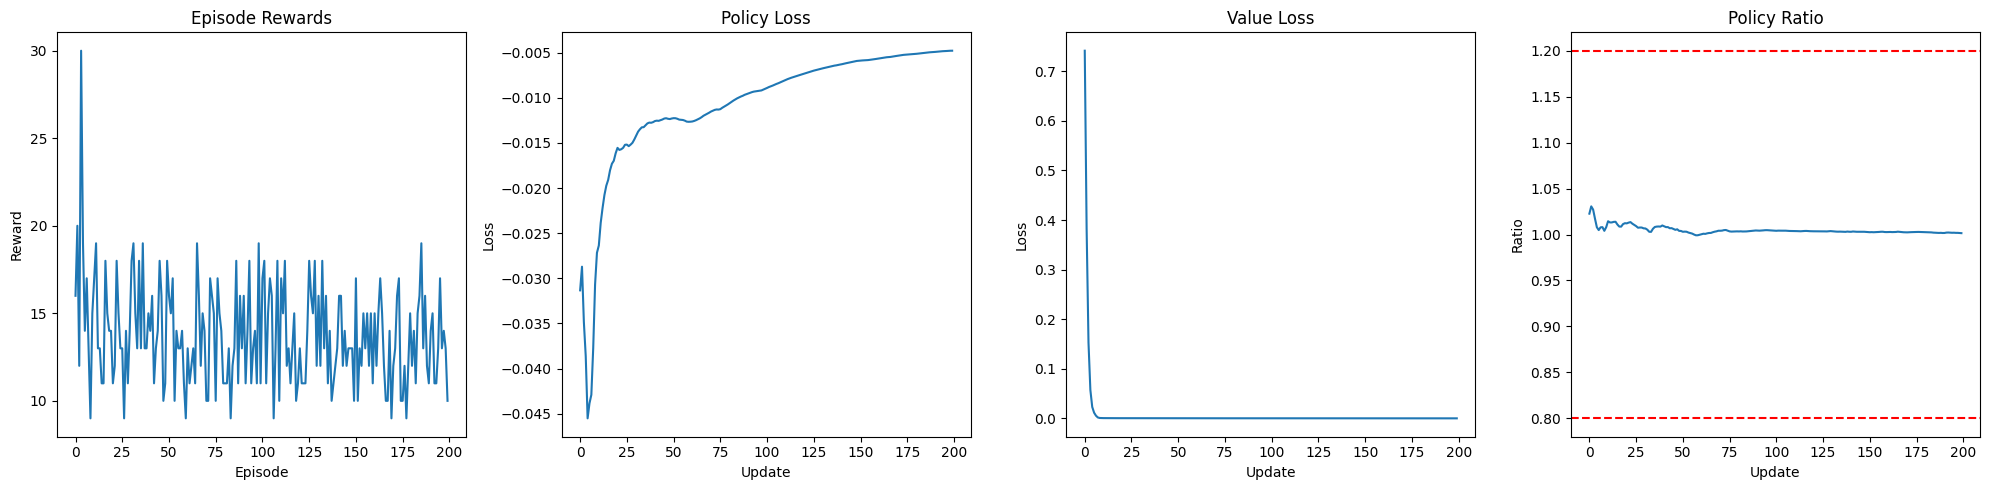

Episode 200, Average Reward: 13.10


In [6]:
import gymnasium as gym
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
# pip uninstall numpy
# pip install numpy==1.24.3

# 策略网络：用于决定在给定状态下采取什么动作
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        # 构建一个三层的神经网络
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),  # 输入层->隐藏层1
            nn.Tanh(),                 # 激活函数
            nn.Linear(64, 64),         # 隐藏层1->隐藏层2
            nn.Tanh(),                 # 激活函数
            nn.Linear(64, action_dim), # 隐藏层2->输出层
            nn.Softmax(dim=-1)         # 将输出转换为概率分布
        )
    
    def forward(self, state):
        return self.network(state)  # 前向传播，输出动作概率

# 价值网络：用于评估状态的价值
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        # 构建一个三层的神经网络
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),  # 输入层->隐藏层1
            nn.Tanh(),                 # 激活函数
            nn.Linear(64, 64),         # 隐藏层1->隐藏层2
            nn.Tanh(),                 # 激活函数
            nn.Linear(64, 1)           # 隐藏层2->输出层（状态价值）
        )
    
    def forward(self, state):
        return self.network(state)  # 前向传播，输出状态价值

# PPO算法的主要实现
class PPO:
    def __init__(self, state_dim, action_dim, lr=0.0003, gamma=0.99, epsilon=0.2):
        # state_dim: 状态维度，在CartPole中是4，表示：
        # 1. 小车的位置 (-4.8 ~ 4.8 米)
        # 2. 小车的速度 (-∞ ~ ∞)
        # 3. 杆子的角度 (-41.8 ~ 41.8 度)
        # 4. 杆子的角速度 (-∞ ~ ∞)
        
        # action_dim: 动作维度，在CartPole中是2，表示：
        # - 向左推
        # - 向右推
        
        # lr (learning rate): 学习率
        # - 控制每次更新网络参数的步长
        # - 太大会不稳定，太小会学习太慢
        
        # gamma: 折扣因子
        # - 用于计算未来奖励的重要性
        # - 接近1表示更重视长期奖励
        # - 接近0表示更重视即时奖励
        
        # epsilon: PPO裁剪参数
        # - 限制策略更新的幅度
        # - 防止一次更新改变太大
        
        # 初始化策略网络和价值网络
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim)
        
        # 创建优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr)
        
        # 设置超参数
        self.gamma = gamma      # 折扣因子
        self.epsilon = epsilon  # PPO裁剪参数
        
        # 存储一个episode的数据
        self.states = []      # 存储所有经历的状态
        self.actions = []     # 存储所有执行的动作
        self.old_probs = []   # 存储动作的原始概率
        self.rewards = []     # 存储获得的奖励
        self.dones = []       # 存储是否结束的标志
        
        # 训练历史记录
        self.rewards_history = []   # 记录每个episode的总奖励
        self.policy_losses = []     # 记录策略网络的损失
        self.value_losses = []      # 记录价值网络的损失
        self.ratios = []           # 记录策略更新的比率
    
    def update(self, states, actions, old_probs, rewards, dones):
        # 计算优势函数
        with torch.no_grad():  # 不计算梯度
            values = self.critic(states)  # 形状例如: [100, 1]
            # 使用价值网络(critic)评估每个状态的价值
            # 例如：states中有100个状态，每个状态得到一个价值估计
            # 获取下一个状态的价值
            # values[1:] 取除了第一个状态之外的所有状态的价值
            # torch.tensor([[0.0]]) 在最后补一个0（因为最后一个状态没有下一个状态）
            next_values = torch.cat([values[1:], torch.tensor([[0.0]])])
            
            # 计算优势函数：Q(s,a) - V(s)
            advantages = rewards.unsqueeze(1) + self.gamma * next_values * (1-dones.unsqueeze(1)) - values
            # 标准化优势函数
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
            advantages = advantages.squeeze(1)
        
        # 创建新的计算图，避免梯度计算错误
        states = states.clone().detach()
        actions = actions.clone().detach()
        old_probs = old_probs.clone().detach()
        advantages = advantages.clone().detach()
        rewards = rewards.clone().detach()
        
        # 记录更新过程中的各种指标
        update_ratios = []
        update_policy_losses = []
        update_value_losses = []
        
        # 多次更新策略和价值网络
        for _ in range(10):
            # 更新策略网络（Actor）
            probs = self.actor(states)  # 获取新的动作概率
            dist = torch.distributions.Categorical(probs)  # 创建概率分布对象
            # 例如：对于向左和向右两个动作
            # probs 可能是 [0.6, 0.4]，表示60%概率向左，40%概率向右
            # 1.2 计算新策略下动作的对数概率
            new_probs = dist.log_prob(actions)  # 计算实际采取的动作在新策略下的概率
            # 1.3 计算新旧策略的比率
            ratio = torch.exp(new_probs - old_probs)  # 新策略概率/旧策略概率
            update_ratios.append(ratio.mean().item())  # 记录平均比率
            
            #裁剪目标函数
            # 2.1 计算未裁剪的目标
            surr1 = ratio * advantages  # 策略比率 × 优势值
            # 2.2 计算裁剪后的目标
            # torch.clamp: 将值限制在指定范围内
            # 例如：如果epsilon=0.2，则ratio被限制在[0.8, 1.2]范围内
            surr2 = torch.clamp(ratio, 1-self.epsilon, 1+self.epsilon) * advantages
            # 2.3 取两者中较小值作为损失
            actor_loss = -torch.min(surr1, surr2).mean()
            # 负号是因为我们要最大化目标函数（最小化负值）

            # 更新策略网络
            # 3.1 清除之前的梯度
            self.actor_optimizer.zero_grad()
            # 3.2 计算梯度
            actor_loss.backward()
            # 3.3 更新网络参数
            self.actor_optimizer.step()
            # 3.4 记录损失值
            update_policy_losses.append(actor_loss.item())
            
            # 更新价值网络（Critic）
            # 4.1 预测状态价值
            value_pred = self.critic(states)
            # 4.2 计算均方误差损失
            # 比较预测值和实际奖励的差距
            critic_loss = nn.MSELoss()(value_pred, rewards.unsqueeze(1))
            # 4.3 更新网络参数
            self.critic_optimizer.zero_grad()  # 清除梯度
            critic_loss.backward()             # 计算梯度
            self.critic_optimizer.step()       # 更新参数
            # 4.4 记录损失值
            update_value_losses.append(critic_loss.item())
        
        # 记录平均策略比率
        self.ratios.append(np.mean(update_ratios))
        # 记录平均策略损失
        self.policy_losses.append(np.mean(update_policy_losses))
        # 记录平均价值损失
        self.value_losses.append(np.mean(update_value_losses))
    
    # 绘制训练过程中的各种指标
    def plot_training_data(self, episode):
        clear_output(wait=True)
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
        
        # 绘制奖励历史
        ax1.plot(self.rewards_history)
        ax1.set_title('Episode Rewards')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Reward')
        
        # 绘制策略损失
        ax2.plot(self.policy_losses)
        ax2.set_title('Policy Loss')
        ax2.set_xlabel('Update')
        ax2.set_ylabel('Loss')
        
        # 绘制价值损失
        ax3.plot(self.value_losses)
        ax3.set_title('Value Loss')
        ax3.set_xlabel('Update')
        ax3.set_ylabel('Loss')
        
        # 绘制策略比率
        ax4.plot(self.ratios)
        ax4.axhline(y=1+self.epsilon, color='r', linestyle='--')
        ax4.axhline(y=1-self.epsilon, color='r', linestyle='--')
        ax4.set_title('Policy Ratio')
        ax4.set_xlabel('Update')
        ax4.set_ylabel('Ratio')
        
        plt.tight_layout()
        plt.show()
    
    # 训练函数
    def train(self, env, episodes=20):
        for episode in range(episodes):
            # 1. 初始化环境
            state, _ = env.reset()         # 重置环境，获取初始状态
            done = False                   # 游戏是否结束
            truncated = False              # 是否达到最大步数
            episode_reward = 0             # 当前回合的总奖励
            
            # 2. 在一个回合中收集数据
            while not (done or truncated):  # 只要游戏没结束就继续
                # 2.1 将状态转换为PyTorch张量
                state_tensor = torch.FloatTensor(state)
                
                # 2.2 使用策略网络选择动作
                probs = self.actor(state_tensor)    # 获取动作概率
                dist = torch.distributions.Categorical(probs)  # 创建概率分布
                action = dist.sample()     # 从分布中采样一个动作
                
                # 2.3 执行动作
                # 这行代码执行动作并获取结果，返回5个值：
                # 1. next_state: 执行动作后的新状态
                #    - 包含4个值 [小车位置, 小车速度, 杆子角度, 杆子角速度]
                #    例如: [-0.2, 0.5, 0.1, -0.3]

                # 2. reward: 这一步的奖励
                #    - 在CartPole中，每保持平衡一步得1分
                #    例如: 1.0

                # 3. terminated: 游戏是否因失败而结束
                #    - True: 游戏失败（杆子倒了或小车出界）
                #    - False: 游戏继续

                # 4. truncated: 是否因达到最大步数而结束
                #    - True: 成功保持平衡500步
                #    - False: 未达到500步

                # 5. _: 其他信息（这里不使用，所以用_忽略）
                next_state, reward, terminated, truncated, _ = env.step(action.item())
                done = terminated
                
                # 2.4 存储这一步的数据
                self.states.append(state_tensor)        # 存储状态
                self.actions.append(action)             # 存储动作
                self.old_probs.append(dist.log_prob(action))  # 存储动作概率
                self.rewards.append(reward)             # 存储奖励
                self.dones.append(float(done))          # 存储是否结束
                
                # 2.5 更新状态和奖励
                state = next_state                      # 更新状态
                episode_reward += reward                # 累加奖励
            
            # 3. 处理收集到的数据
            # 将列表转换为张量，方便后续计算
            states = torch.stack(self.states)          # 状态张量
            actions = torch.stack(self.actions)        # 动作张量
            old_probs = torch.stack(self.old_probs)    # 概率张量
            rewards = torch.FloatTensor(self.rewards)  # 奖励张量
            dones = torch.FloatTensor(self.dones)      # 结束标志张量
            
            # 4. 更新策略
            self.update(states, actions, old_probs, rewards, dones)  # 更新网络
            self.rewards_history.append(episode_reward)  # 记录这个回合的总奖励
            
            # 5. 每10个回合显示一次训练进度
            if (episode + 1) % 100 == 0:  # 每训练10个回合
                self.plot_training_data(episode)  # 绘制训练图表
                # 打印最近10个回合的平均奖励
                print(f"Episode {episode+1}, Average Reward: {np.mean(self.rewards_history[-10:]):.2f}")

# 主程序
if __name__ == "__main__":
    # 创建CartPole环境
    env = gym.make('CartPole-v1', render_mode="human")
    # 获取状态和动作空间的维度
    state_dim = env.observation_space.shape[0]  # 值为4，表示：
    # 1. 小车的位置 (-4.8 ~ 4.8 米)
    # 2. 小车的速度 (-∞ ~ ∞)
    # 3. 杆子的角度 (-41.8 ~ 41.8 度)
    # 4. 杆子的角速度 (-∞ ~ ∞)
    action_dim = env.action_space.n             # 值为2，表示：
    # - 向左推
    # - 向右推
    
    # 创建PPO实例
    ppo = PPO(state_dim, action_dim)
    # 开始训练
    ppo.train(env, episodes=200)
    # 关闭环境
    env.close()



<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250318164847605.png" width=100%></div>

# 6.总结

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250318164644967.png" width=100%></div>